**Importer des bibliothèques**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import skimage.io
from tqdm import tqdm
import cv2
import os
import keras.backend as K
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import ResNet50
from keras.applications.nasnet import NASNetLarge
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# **Charger les données et tracer les échantillons**

In [1]:
from zipfile import ZipFile
file_name = "data_DL.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

BadZipFile: ignored

In [ ]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [ ]:
def load_data(dir_path, IMG_SIZE):

    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images chargées à partir le répertoire: {dir_path}.')
    return X, y, labels

In [ ]:
IMG_SIZE= (48, 48)

In [ ]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


28273 images chargées à partir le répertoire: Training/Training/.


In [ ]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 11.45it/s]


7067 images chargées à partir le répertoire: Testing/Testing/.


In [ ]:
test_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

In [ ]:
plot_samples(X_train, y_train, train_labels, 10)

**Classes d'encodage**


In [ ]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(28273, 6)

In [ ]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

# **Modélisme**

#1) VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [ ]:
def deep_model(model, X_train, Y_train, epochs, batch_size):

    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1)
    return history

In [ ]:
epochs = 40
batch_size = 64

history = deep_model(model, X_train, Y_train, epochs, batch_size)


Epoch 1/40
442/442 [==============================] - 39s 62ms/step - loss: 0.4619 - accuracy: 0.2477
Epoch 2/40
442/442 [==============================] - 27s 60ms/step - loss: 0.4469 - accuracy: 0.2506
Epoch 3/40
442/442 [==============================] - 27s 61ms/step - loss: 0.4077 - accuracy: 0.3382
Epoch 4/40
442/442 [==============================] - 28s 64ms/step - loss: 0.3673 - accuracy: 0.4209
Epoch 5/40
442/442 [==============================] - 29s 65ms/step - loss: 0.3413 - accuracy: 0.4689
Epoch 6/40
442/442 [==============================] - 28s 64ms/step - loss: 0.3218 - accuracy: 0.5122
Epoch 7/40
442/442 [==============================] - 28s 64ms/step - loss: 0.3029 - accuracy: 0.5524
Epoch 8/40
442/442 [==============================] - 28s 64ms/step - loss: 0.2850 - accuracy: 0.5875
Epoch 9/40
442/442 [==============================] - 28s 64ms/step - loss: 0.2657 - accuracy: 0.6255
Epoch 10/40
442/442 [==============================] - 28s 64ms/step - loss: 0.245

**Matrice de confusion**




In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Véritable étiquette')
    plt.xlabel('étiquette prédite ')
    plt.show()

221/221 [==============================] - 3s 12ms/step
Précision du test = 0.59


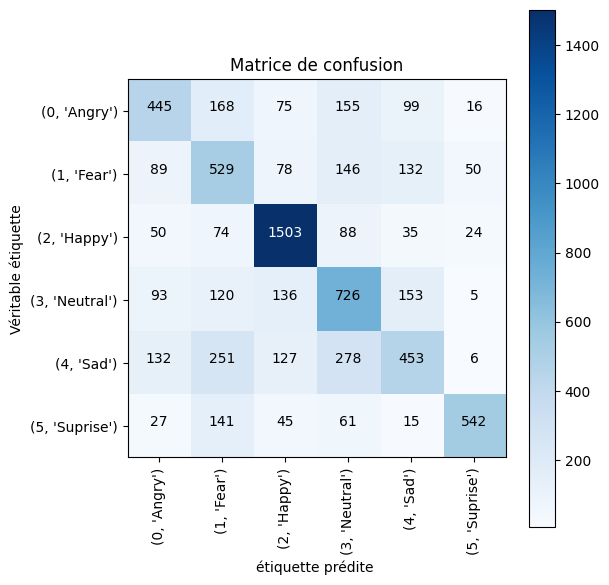

In [ ]:
# Valider sur jeu de test

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Précision du test = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

**Essayons notre modèle et faisons des prédictions**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [ ]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

221/221 [==============================] - 3s 12ms/step


In [ ]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [ ]:
import pandas as pd

pred_result = pd.DataFrame({"Nom de fichier":filenames,
                           "Prédictions":y_pred,
                           "Valeurs réelles":actual_class})

pred_result.head()

,Nom de fichier,Prédictions,Valeurs réelles
0,Angry/Angry-1.jpg,Angry,Angry
1,Angry/Angry-10.jpg,Fear,Angry
2,Angry/Angry-100.jpg,Angry,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Neutral,Angry


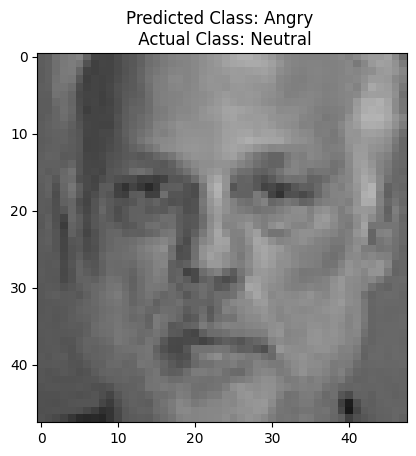

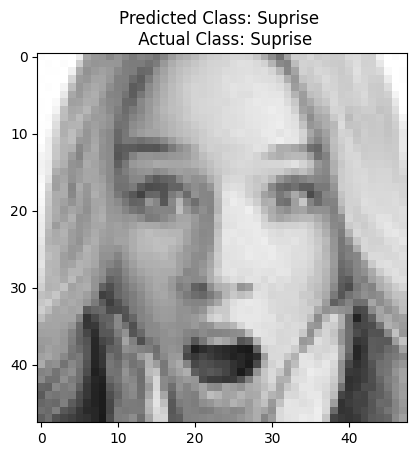

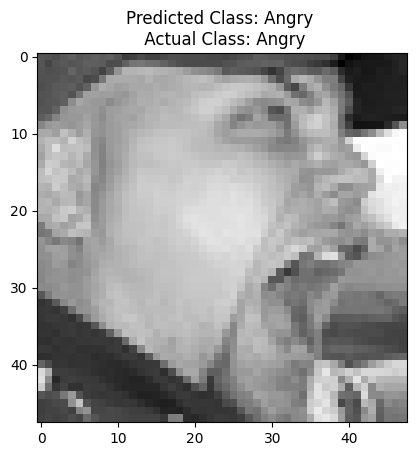

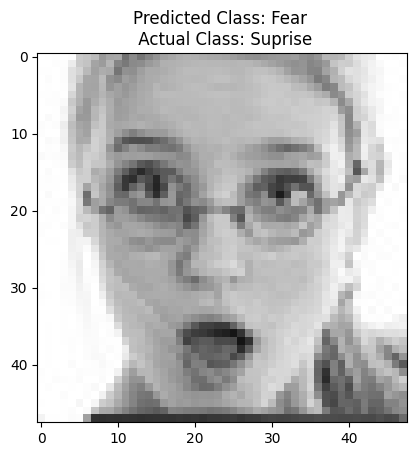

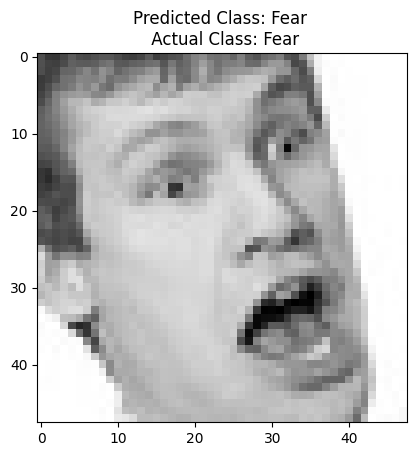

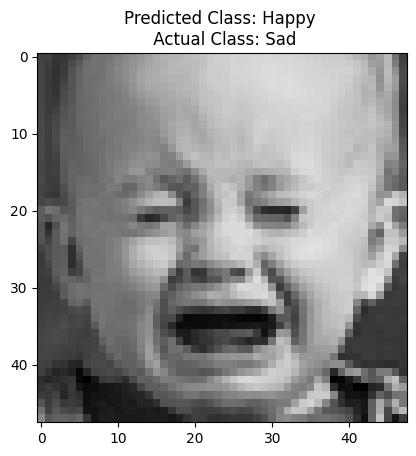

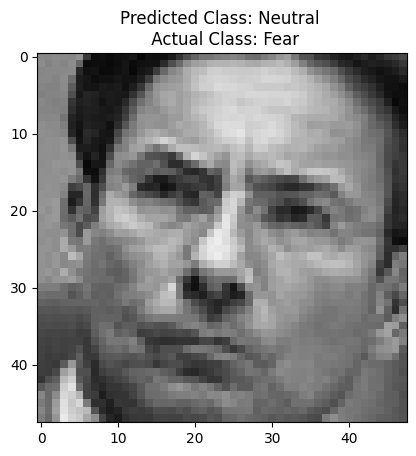

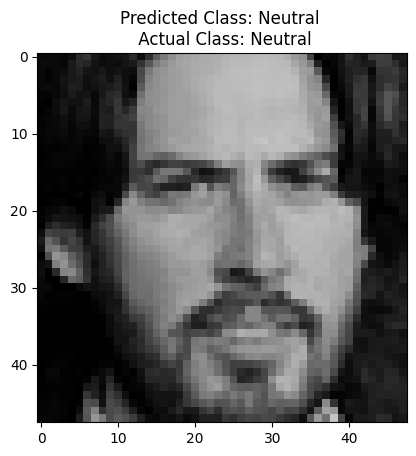

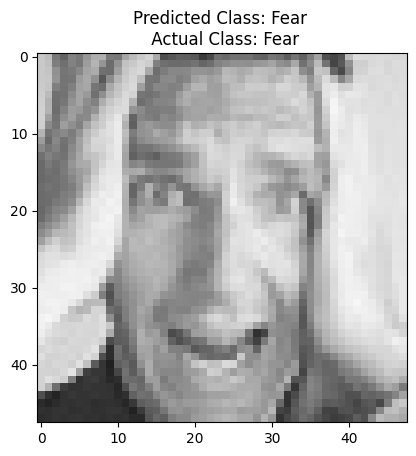

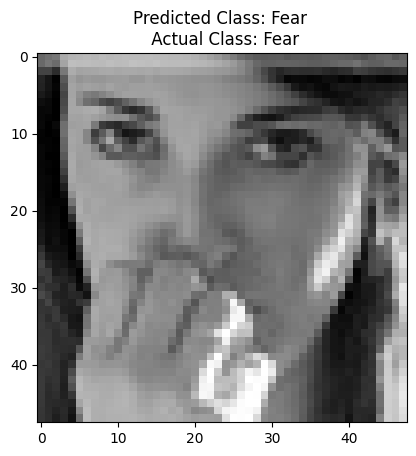

In [ ]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images

    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]

    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass

#2)ResNet50


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Training/Training/',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22619 images belonging to 6 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Training/Training/',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5654 images belonging to 6 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = 'Testing/Testing/',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7067 images belonging to 6 classes.


(48, 48, 3)
(1, 48, 48, 3)


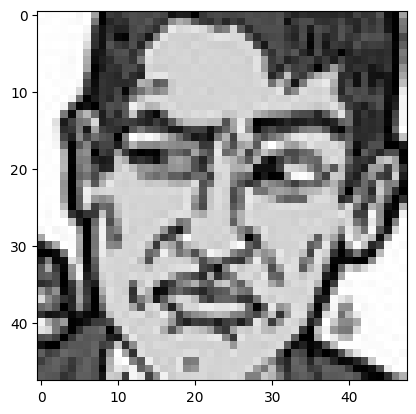

In [ ]:
import keras.utils as image
img = image.load_img("Testing/Testing/Angry/Angry.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="Training/Training/")

94765736/94765736 [==============================] - 3s 0us/step


# Freezing Layers

In [ ]:


for layer in base_model.layers[:-4]:
    layer.trainable=False

#Building Model

In [ ]:


model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(6,activation='softmax'))

#Model Summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

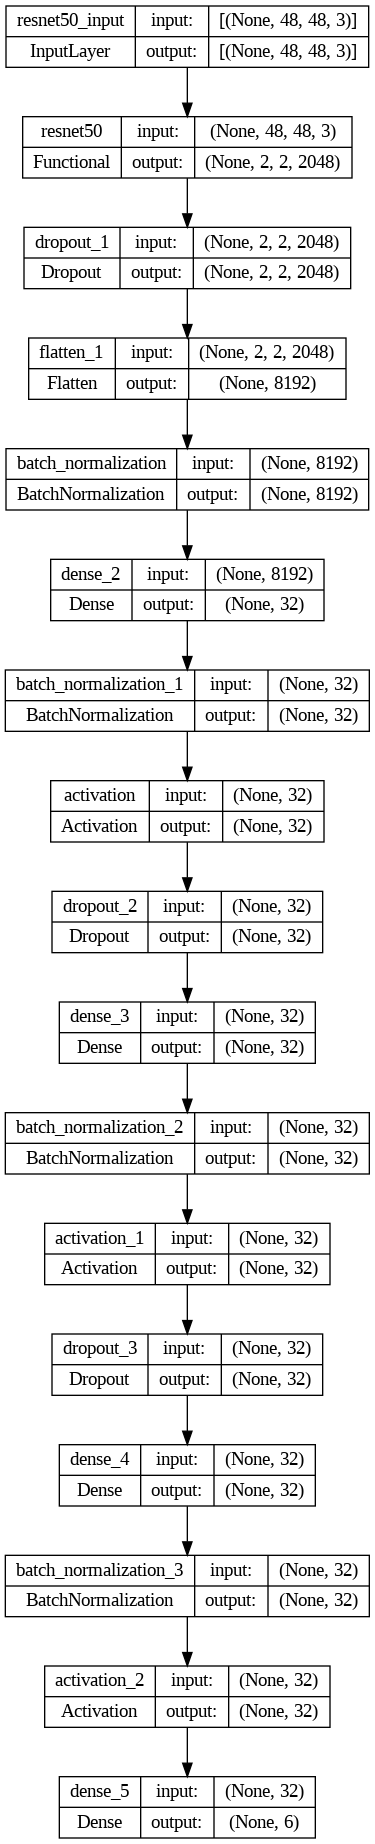

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 40,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/40
354/354 [==============================] - 52s 122ms/step - loss: 1.8609 - accuracy: 0.8300 - precision: 0.1916 - recall: 0.0063 - auc: 0.5401 - f1_score: 0.0118 - val_loss: 1.7762 - val_accuracy: 0.8332 - val_precision: 0.1250 - val_recall: 1.7687e-04 - val_auc: 0.5717 - val_f1_score: 3.4572e-04 - lr: 0.0010
Epoch 2/40
354/354 [==============================] - 39s 110ms/step - loss: 1.7817 - accuracy: 0.8329 - precision: 0.2455 - recall: 0.0012 - auc: 0.5717 - f1_score: 0.0023 - val_loss: 1.7550 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5883 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/40
354/354 [==============================] - 39s 110ms/step - loss: 1.7690 - accuracy: 0.8332 - precision: 0.2667 - recall: 3.5368e-04 - auc: 0.5798 - f1_score: 6.9535e-04 - val_loss: 1.7620 - val_accuracy: 0.8333 - val_precision: 0.3333 - val_recall: 3.5373e-04 - val_auc: 0.5777 - val_f1_score: 6.9144e-04 - lr: 0.0010
Epoch 4/40
354/354 [==

#PLOTTING RESULTS

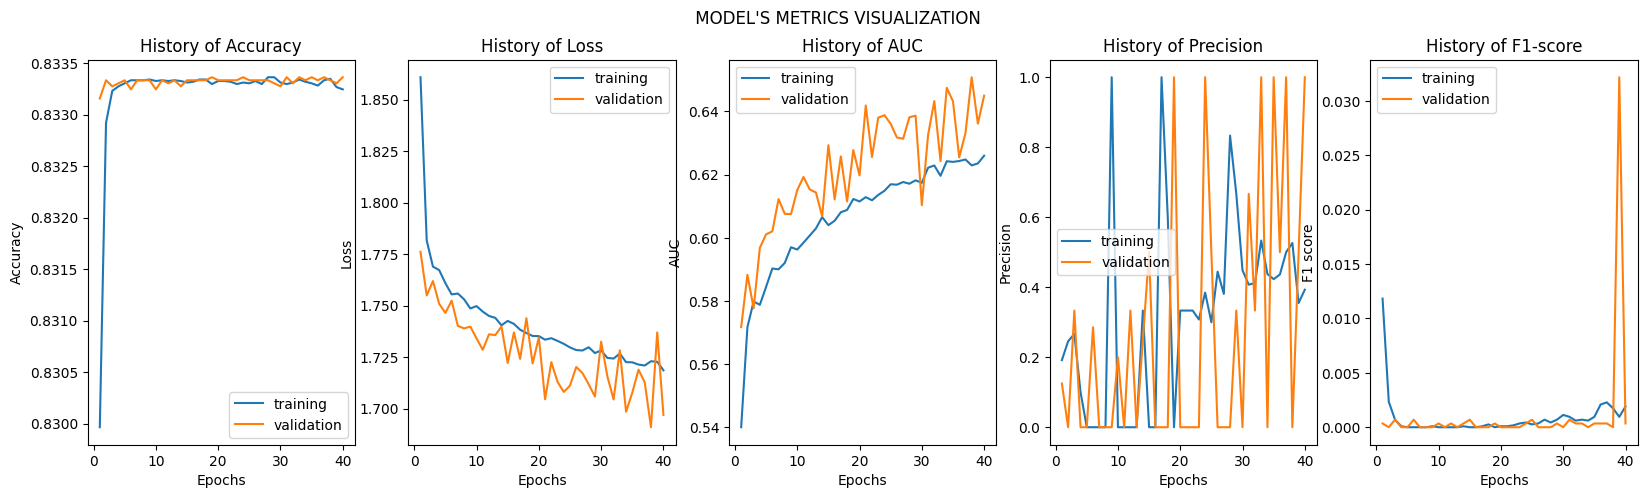

In [ ]:


def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )